In [1]:
import os

import numpy as np

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib.patches import Rectangle

import torch
device = torch.device("cuda:1" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")

import sys
sys.path.append("..")
import models
import h5py
import data
import inference


%load_ext autoreload
%autoreload 2

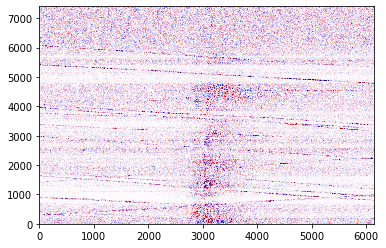

In [2]:
fs = 50.0

file = '../data/preprocessed/real_test/2023p181489.h5'
idx = 6250
#indices = [6250,5250,5500,6250,6750,7250]

with h5py.File(file, 'r') as hf:
    samples = hf['DAS'][81:,idx-3072:idx+3072]

gutter = 1000
x = np.pad(samples[None,:], ((0,0),(0,0),(gutter,gutter)), mode='constant', constant_values=0)
x = data.bandpass(x, low=1.0, high=10.0, fs=fs, gutter=gutter)[0]
x = x / x.std(axis=-1, keepdims=True)
np.save('../data/2023p181489_input.npy', x)

plt.imshow(x, origin='lower', interpolation='antialiased', cmap='seismic', aspect='auto', vmin=-1, vmax=1)

In [3]:
if not os.path.isfile('../data/2023p181489_output-synth.npy'):

    model = models.CN2SUNet(1, 1, hidden_ch=32, n_layers=4).to(device)
    model.load_state_dict(torch.load('../ckpt/CN2S-synthetic4-complement-128x512-16x180_200.pt'))
    model.eval()

    rec = inference.xreconstruct(model, torch.from_numpy(x).to(device), 128, 512, 16, nx_stride=6, nt_stride=50, batch_size=128, dx=4, verbose=False)
    rec_filt = np.pad(rec.cpu().numpy()[None,:], ((0,0),(0,0),(gutter,gutter)), mode='constant', constant_values=0)
    rec_filt = data.bandpass(rec_filt, low=1.0, high=10.0, fs=fs, gutter=gutter)[0]

    np.save('../data/2023p181489_output-synth.npy', rec_filt)

In [5]:
if not os.path.isfile('../data/2023p181489_output-real.npy'):

    model = models.CN2SUNet(1, 1, hidden_ch=32, n_layers=4).to(device)
    model.load_state_dict(torch.load('../ckpt/CN2S-real4-complement-128x512-16x180_200.pt'))
    model.eval()

    rec = inference.xreconstruct(model, torch.from_numpy(x).to(device), 128, 512, 16, nx_stride=6, nt_stride=50, batch_size=128, dx=4, verbose=False)
    rec_filt = np.pad(rec.cpu().numpy()[None,:], ((0,0),(0,0),(gutter,gutter)), mode='constant', constant_values=0)
    rec_filt = data.bandpass(rec_filt, low=1.0, high=10.0, fs=fs, gutter=gutter)[0]

    np.save('../data/2023p181489_output-real.npy', rec_filt)

100%|██████████| 1235/1235 [09:37<00:00,  2.14it/s]


In [6]:
if not os.path.isfile('../data/2023p181489_output.npy'):

    model = models.CN2SUNet(1, 1, hidden_ch=32, n_layers=4).to(device)
    model.load_state_dict(torch.load('../ckpt/CN2S-finetuned4-complement-128x512-16x180_200.pt'))
    model.eval()

    rec = inference.xreconstruct(model, torch.from_numpy(x).to(device), 128, 512, 16, nx_stride=6, nt_stride=50, batch_size=128, dx=4, verbose=False)
    rec_filt = np.pad(rec.cpu().numpy()[None,:], ((0,0),(0,0),(gutter,gutter)), mode='constant', constant_values=0)
    rec_filt = data.bandpass(rec_filt, low=1.0, high=10.0, fs=fs, gutter=gutter)[0]

    np.save('../data/2023p181489_output.npy', rec_filt)

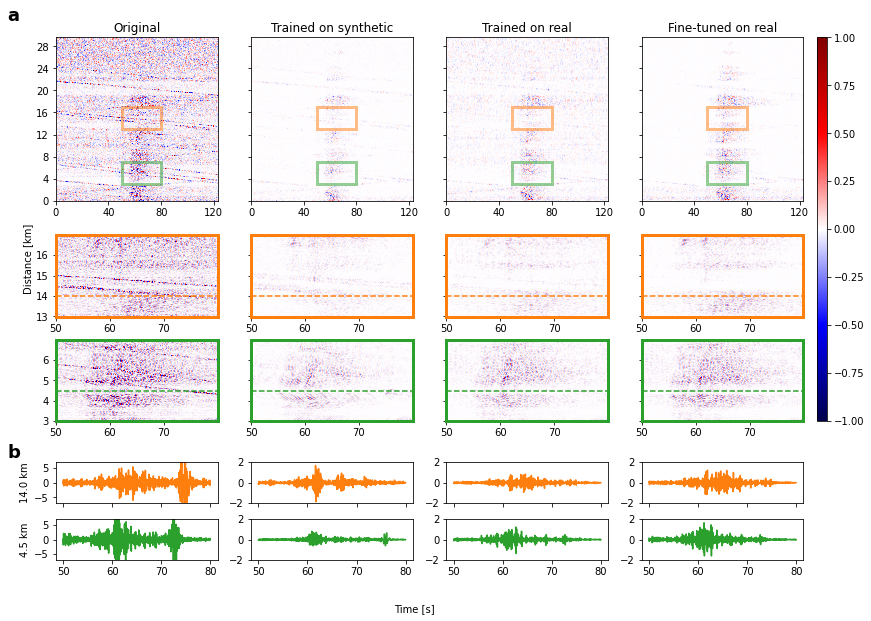

In [40]:

xx1 = np.load('../data/2023p181489_output-synth.npy')
xx2 = np.load('../data/2023p181489_output-real.npy')
xx3 = np.load('../data/2023p181489_output.npy')

x1, y1 = 2500, 13000 // 4
x2, y2 = 2500, 3000 // 4
w, h = 1500, 4000 // 4

lw = 3
alpha = 0.5

fig, axs = plt.subplot_mosaic([['a', 'b', 'a1', 'aa1'], 
                                ['a', 'b', 'a1', 'aa1'],
                                ['a', 'b', 'a1', 'aa1'],
                                ['a', 'b', 'a1', 'aa1'], 
                                ['c', 'd', 'a2', 'aa2'],
                                ['c', 'd', 'a2', 'aa2'],
                                ['e', 'f', 'a3', 'aa3'],
                                ['e', 'f', 'a3', 'aa3'],
                                ['x1', 'x2', 'x3', 'x4'],
                                ['y1', 'y2', 'y3', 'y4'],],
                                layout='constrained', figsize=(12,8))

vmin = -1
vmax = 1
axs['a'].imshow(x, origin='lower', interpolation='antialiased', cmap='seismic', aspect='auto', vmin=vmin, vmax=vmax)
axs['a'].set_title('Original')
axs['b'].imshow(xx1, origin='lower', interpolation='antialiased', cmap='seismic', aspect='auto', vmin=vmin, vmax=vmax)
axs['b'].set_title('Trained on synthetic')
axs['a'].add_patch(Rectangle((x1, y1), w, h, linewidth=lw, edgecolor='tab:orange', facecolor='none', alpha=alpha))
axs['b'].add_patch(Rectangle((x1, y1), w, h, linewidth=lw, edgecolor='tab:orange', facecolor='none', alpha=alpha))
axs['a'].add_patch(Rectangle((x2, y2), w, h, linewidth=lw, edgecolor='tab:green', facecolor='none', alpha=alpha))
axs['b'].add_patch(Rectangle((x2, y2), w, h, linewidth=lw, edgecolor='tab:green', facecolor='none', alpha=alpha))
axs['c'].imshow(x[y1:y1+h, x1:x1+w], origin='lower', interpolation='antialiased', cmap='seismic', aspect='auto', vmin=vmin, vmax=vmax)
axs['d'].imshow(xx1[y1:y1+h, x1:x1+w], origin='lower', interpolation='antialiased', cmap='seismic', aspect='auto', vmin=vmin, vmax=vmax)
axs['e'].imshow(x[y2:y2+h, x2:x2+w], origin='lower', interpolation='antialiased', cmap='seismic', aspect='auto', vmin=vmin, vmax=vmax)
axs['f'].imshow(xx1[y2:y2+h, x2:x2+w], origin='lower', interpolation='antialiased', cmap='seismic', aspect='auto', vmin=vmin, vmax=vmax)

axs['a1'].imshow(xx2, origin='lower', interpolation='antialiased', cmap='seismic', aspect='auto', vmin=vmin, vmax=vmax)
axs['a1'].set_title('Trained on real')
im = axs['aa1'].imshow(xx3, origin='lower', interpolation='antialiased', cmap='seismic', aspect='auto', vmin=vmin, vmax=vmax)
axs['aa1'].set_title('Fine-tuned on real')
axs['a1'].add_patch(Rectangle((x1, y1), w, h, linewidth=lw, edgecolor='tab:orange', facecolor='none', alpha=alpha))
axs['a1'].add_patch(Rectangle((x2, y2), w, h, linewidth=lw, edgecolor='tab:green', facecolor='none', alpha=alpha))
axs['a2'].imshow(xx2[y1:y1+h, x1:x1+w], origin='lower', interpolation='antialiased', cmap='seismic', aspect='auto', vmin=vmin, vmax=vmax)
axs['a3'].imshow(xx2[y2:y2+h, x2:x2+w], origin='lower', interpolation='antialiased', cmap='seismic', aspect='auto', vmin=vmin, vmax=vmax)
axs['aa1'].add_patch(Rectangle((x1, y1), w, h, linewidth=lw, edgecolor='tab:orange', facecolor='none', alpha=alpha))
axs['aa1'].add_patch(Rectangle((x2, y2), w, h, linewidth=lw, edgecolor='tab:green', facecolor='none', alpha=alpha))
axs['aa2'].imshow(xx3[y1:y1+h, x1:x1+w], origin='lower', interpolation='antialiased', cmap='seismic', aspect='auto', vmin=vmin, vmax=vmax)
axs['aa3'].imshow(xx3[y2:y2+h, x2:x2+w], origin='lower', interpolation='antialiased', cmap='seismic', aspect='auto', vmin=vmin, vmax=vmax)
fig.colorbar(im, ax=[axs['aa1'], axs['aa2'], axs['aa3']], location='right', shrink=1, aspect=40, pad=0.05)

axs['c'].set_xticks([i for i in range(0,w,500)])
axs['d'].set_xticks([i for i in range(0,w,500)])
axs['e'].set_xticks([i for i in range(0,w,500)])
axs['f'].set_xticks([i for i in range(0,w,500)])

axs['a'].yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{int((x * 4 * 0.001))}')) # 4.083809535485629
axs['a1'].yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{int((x * 4 * 0.001))}'))
axs['a'].xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{int((x / 50))}'))
axs['b'].xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{int((x / 50))}'))
axs['a1'].xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{int((x / 50))}'))
axs['aa1'].xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{int((x / 50))}'))

axs['c'].yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{int(((x + y1) * 4 * 0.001))}'))
axs['e'].yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{int(((x + y2) * 4 * 0.001))}'))
axs['a2'].yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{int(((x + y1) * 4 * 0.001))}'))
axs['a3'].yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{int(((x + y2) * 4 * 0.001))}'))
axs['aa2'].yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{int(((x + y1) * 4 * 0.001))}'))
axs['aa3'].yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{int(((x + y2) * 4 * 0.001))}'))

axs['c'].xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{int(((x + x1) / 50))}'))
axs['d'].xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{int(((x + x1) / 50))}'))
axs['e'].xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{int(((x + x2) / 50))}'))
axs['f'].xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{int(((x + x2) / 50))}'))
axs['a2'].xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{int(((x + x1) / 50))}'))
axs['a3'].xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{int(((x + x2) / 50))}'))
axs['aa2'].xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{int(((x + x1) / 50))}'))
axs['aa3'].xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{int(((x + x2) / 50))}'))

for a in ['c', 'd', 'a2', 'aa2']:
    for b in ['bottom', 'top', 'right', 'left']:
        axs[a].spines[b].set_color('tab:orange')
        axs[a].spines[b].set_linewidth(lw)
for a in ['e', 'f', 'a3', 'aa3']:
    for b in ['bottom', 'top', 'right', 'left']:
        axs[a].spines[b].set_color('tab:green')
        axs[a].spines[b].set_linewidth(lw)

axs['b'].set_yticklabels([])
axs['d'].set_yticklabels([])
axs['f'].set_yticklabels([])
axs['a1'].set_yticklabels([])
axs['a2'].set_yticklabels([])
axs['a3'].set_yticklabels([])
axs['aa1'].set_yticklabels([])
axs['aa2'].set_yticklabels([])
axs['aa3'].set_yticklabels([])

ch1 = 14000 // 4
ch2 = 4500 // 4 #4460

for s in ['c', 'd', 'a2', 'aa2']:
    axs[s].axhline(ch1 - y1, ls="--", c="tab:orange")
for s in ['e', 'f', 'a3', 'aa3']:
    axs[s].axhline(ch2 - y2, ls="--", c="tab:green")
    
axs['x1'].plot(x[ch1,x1:x1+w], c='tab:orange')
axs['y1'].plot(x[ch2,x2:x2+w], c='tab:green')
axs['x2'].plot(xx1[ch1,x1:x1+w], c='tab:orange')
axs['y2'].plot(xx1[ch2,x2:x2+w], c='tab:green')
axs['x3'].plot(xx2[ch1,x1:x1+w], c='tab:orange')
axs['y3'].plot(xx2[ch2,x2:x2+w], c='tab:green')
axs['x4'].plot(xx3[ch1,x1:x1+w], c='tab:orange')
axs['y4'].plot(xx3[ch2,x2:x2+w], c='tab:green')

axs['x1'].set_ylabel('{:.1f} km'.format(ch1*4 / 1000))
axs['y1'].set_ylabel('{:.1f} km'.format(ch2*4 / 1000))
for s in ['x1', 'y1']:
    axs[s].set_ylim((-7,7))
for s in ['x2', 'x3', 'x4', 'y2', 'y3', 'y4']:
    axs[s].set_ylim((-2,2))
for s in ['x1', 'x2', 'x3', 'x4']:
    axs[s].set_xticklabels([])
for s in ['y1', 'y2', 'y3', 'y4']:
    axs[s].xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{int(((x + x1) / 50))}'))

#axs['c'].set_ylabel('Distance [km]')

axs['a'].text(-0.3, 1.1, 'a', transform=axs['a'].transAxes, size=18, weight='bold')
axs['x1'].text(-0.3, 1.1, 'b', transform=axs['x1'].transAxes, size=18, weight='bold')

axs['c'].text(-0.2, 0.3, 'Distance [km]', transform=axs['c'].transAxes, rotation='vertical')
#axs['c'].set_ylabel('Distance [km]')
fig.text(0.475, -0.05, 'Time [s]', ha='center', va='center')

plt.savefig('./out/figure_A3.pdf', bbox_inches='tight', dpi=200)
plt.show()